# Classifying college basketball tournament upsets with machine learning
In this notebook I perform exploratory analyses and machine learning on a dataset of 14 years of men's college basketball tournament games, from 2002 to 2016. The goal is to build a classification model to predict upsets in future games. 

### The definition of an "upset"
In sports terminology, an "upset" occurs when the team that's expected to lose (aka the "underdog") wins a game. Upsets happen across all sports, but the annual tournament for the men's college basketball championship is famous for them, for a few different reasons: 
- **The single-elimination format**. Win and advance, or lose and your season is over. The stakes of each game are incredibly high, which adds extra shock value to the major upsets. 
- **Bids from all conferences**. The champions of 34 conferences receive an invite to the tournament, and remaining slots are filled with at-large invites. Because of this "equal opportunity" format, many games feature smaller schools with less resources against powerhouse programs with future NBA stars. In most sports, the playoffs feature only the most elite teams, so the college hoops tournament is unique for its wealth of upset opportunities.  
- **Neutral game locations**. Games are played in neutral arenas around the country, not in any team's home gym. The absence of a "true" home court advantage creates a more even playing field. And if an underdog can keep the score close, fans in the arena will often end up pulling for the upset. 

### Motivation: The value of accurate upset prediction
By definition, upsets are events that are considered unlikely to happen. But underdogs still win relatively often, about 20% of the time, and every year a few highly-ranked teams lose earlier than expected. Accurate upset forecasts are useful for millons of fans who fill out tournament brackets each year. Accurate upset prediction predictions are also valuable for sports gambling, because correct bets on underdogs typically provide a higher rate of return than bets on favored teams. 

## Introduction
In my previous work on this project I acquired the data, performed data cleaning, and did some feature engineering operations. These steps produced a dataset of tournament games from 1985 to 2016, with the winner of each game and 80 features for both teams. In this notebook I use this data to build a model for predicting future upsets. 

First I import several packages and tools for data manipulation and analysis. 

In [1]:
# for data importing and wrangling
import pandas as pd
import numpy as np

# for data processing, model training, and scoring
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (f1_score, accuracy_score, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, precision_recall_curve)
from sklearn.preprocessing import StandardScaler

# classification algorithms
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# for random grid search
from scipy.stats import uniform as sp_uniform

I also set some display and plot preferences for the notebook. 

In [2]:
# plot tools and preferences
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

# create a list of colors from matplotlib ggplot style
colors = []
for j, c in zip(range(8), plt.rcParams['axes.prop_cycle']):
    colors.append((j, c)[1].get('color'))
gg_blue = colors[1]
gg_red = colors[0]

# remove display limits
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# use future division to show percentages
from __future__ import division

## Data preparation

To begin data preparation, I import the data. I also remove rows with missing data on the features, which I know includes years prior to 2002. The classification algorithms I use don't allow missing data. Another option would be to impute the missing data, but to estblish a baseline level of upset prediction performance, I chose the simpler approach of using complete data.  

In [3]:
# import the data
df = pd.read_csv('../data/ncaa/matchups.csv')
# select years with complete data, 2003 and above
df = df[df.season >= 2003]

### Select games relevant for upset prediction
The dataset includes all tournament games from 2003 to 2016. Because the end goal is to create a model specifically for predicting upsets, I will only use games where there is a clear favorite and underdog. One way to determine this would be to use Vegas odds or point spreads, but a reasonable shortcut is to use the team seeds. Before the tournament begins, each team is assigned a "seed" to indicate their ranking, from 1 (best) to 16 (worst). A win by a team with a much higher numerical seed than their opponent typically qualifies as an upset.

To create a dataset of relevant games, I selected games between teams with a seed difference of at least 4, such as 1-seed vs 5-seed, 2-seed vs 6-seed, 3-seed vs 7-seed, and so on. The dataset already includes this information, in a numeric column that contains the teams' seed difference, and a dichotomous column that indicates whether the seed difference is at least 4. 

Below I verify that the upset-potential games only include the games with at-least a 4-point seed difference. 

In [4]:
# to verify minimum seed difference for "upset-potential" group
df.groupby('upsetpot')['seedif'].describe()

,count,mean,std,min,25%,50%,75%,max
upsetpot,,,,,,,,
0,330.0,1.633333,1.097986,0.0,1.0,1.0,3.0,3.0
1,584.0,8.636986,3.289111,4.0,6.0,8.0,11.0,15.0


For rows where "upsetpot" equals 1, the minimum seed difference is indeed 4. 

By selecting these rows, I keep only the upset-potential games in the dataset. I also remove some other irrelevant columns.  

In [5]:
# to train only on games meeting the upset-potential criteria
df = df[df['upsetpot'] == 1]
# remove some irrelevant features
df = df.drop(['upsetpot', 'rnd', 'seedif', 'daynum', 
              'win_t2', 't1_team_id', 't2_team_id'], axis=1)

## Creating a training set and test set
My plan is to train a classification model using 80% of the data as a training set, and test the performance of the model using the remaining 20% as a test set. By "holding out" the test set during the model training and tuning process, I can use the test set later to estimate the model's performance on future, unseen data. 

A popular way to perform a train-test split is to split the data randomly, but I believe that isn't the best choice for this dataset, because examples are related to each other. The same team can have multiple games in the dataset. With a random split, I could end up with the same team having examples in the training and test set, which would bias the model performance on the test set.

For this reason, I split the data chronologically, by placing the most recent ~20% of games in the test set. By training on games that occured first in chronological order, and testing on games that occurred later, I will also train and test the model using a similar method to the way it would be trained and deployed in practice. 

To determine where to split the data, I examine the proportion of the data that would be split into the training set for each year. 

In [6]:
# group by season, count games, get cumulative sum
# get percentile of all games occurring by end of each season
df.groupby(['season'])['upset'].count().cumsum() / df.shape[0]

season
2003    0.070205
2004    0.140411
2005    0.214041
2006    0.291096
2007    0.357877
2008    0.424658
2009    0.488014
2010    0.565068
2011    0.636986
2012    0.705479
2013    0.777397
2014    0.852740
2015    0.924658
2016    1.000000
Name: upset, dtype: float64

The games occuring from 2003-2013 contain 78% of the examples, so I use those games as training set, and the games from 2014-2016 as the test set. To mark the examples as in the training or test set, I create a boolean (True/False) vector. 

In [7]:
# create boolean to indicate if row is in test set
test_set = df['season'] > 2013
# remove season from the data
df = df.drop('season', axis=1)

Now that I have a vector that marks the training and test set examples, I use it to create separate vectors of the "upset" target for the training and test sets. I also remove the "upset" column from the game data, so the remaining columns includes only predictive features for the two teams in the matchup.

In [8]:
# create separate vectors of upset labels for training and test set
y_test = df[test_set]['upset'].values
y_train = df[~test_set]['upset'].values
# remove upset column from data
df = df.drop('upset', axis=1)

Through a prior data exploration and visualization project, I have a list of 20 features I want to include in the next phase of the analysis. Here I subset the features data to include only these features. 

In [9]:
# list of strings that are suffixes for the features to include
feat_suff = ['seed', 'adjoe', 'adjde', 'em', 'dist', 'texp', 'orbtomarg', 'sos',
            'cvisits', 'cfar']

# feature names are the suffix strings preceded by either 't1_' or 't2_'
feat_list = ['t1_' + x for x in feat_suff] + ['t2_' + x for x in feat_suff]

# retain only the features on the list in the dataset
df = df[feat_list]

As I did with the "upset" target variable, I split the features into training and test sets. Because some of the features have much larger values than others, I also standardize all of the features to a similar scale, to prevent large differences in scale between features from having an impact on the model. 

In [10]:
# initialize object to scale features
sc = StandardScaler()

# fit the scaler object using the training set
# values converted to float type for the scaler conversion
x_train = sc.fit_transform(df[~test_set].astype(float))

# transform test set using training set parameters
x_test = sc.transform(df[test_set].astype(float))

In [11]:
# print size of training and test sets
print 'shape of training set features'
print x_train.shape
print 'number of training set targets'
print len(y_train)
print 'shape of test set features'
print x_test.shape
print 'number of test set targets'
print len(y_test)

shape of training set features
(454L, 20L)
number of training set targets
454
shape of test set features
(130L, 20L)
number of test set targets
130


Now that the features and labels have been separated into training and test sets, I'm ready to use the training set to start exploring the features and building a classification model.  

## Exploring features for the model

The features data includes 10 numeric features on each underdog and favorite involved the game. Half of these features are computed from the team's performance during the season leading up to the championship tournament. 

- **Scoring margin:** The average amount that a team outscores their opponents, adjusted for pace and opponents.
- **Offensive rebound & turnover margins:** Average advantage in offensive rebounds + turnovers compared to opponents, which is an indicator of a team's "extra" opportunities to score. 
- **Strength of schedule:** An index of the difficulty of opponents that a team played during the season.
- **Offensive efficiency:** Points per game scored on offense, adjusted for pace and opponents.
- **Defensive efficiency:** Points per game allowed on defense, adjusted for pace and opponents.

The remaining half of the features measure the players' and coach's previous tournament experience, or other aspects of the team's tournament matchup. 
- **Coach success**: An index of the coach's maximum level of success in any prior championship tournament.
- **Coach experience**: An index of the coach's cumulative amount of tournament experience. 
- **Player experience**: An index of the total amount of previous tournament experience for the team's players. 
- **Team Seed**: The ranking assigned to the team prior to the tournament, from 1 (best) to 16 (worst). 
- **Travel distance**: Distance (in miles) from the team's home campus to the game. 

### Examining correlations between features

Below I create a function to plot a heat map of the feature correlation matrix to examine the degree of association between the features in this dataset. The function allows me to plot the correlation matrix separately for favorites and underdogs. 

In [12]:
# create a dictionary of feature labels for plots
feat_dict = {'seed': "Team Seed",
             'adjoe': 'Offensive Efficiency',
             'adjde': 'Defensive Efficiency',
             'em': 'Scoring Margin',
             'dist': 'Travel Distance',
             'texp': 'Player Experience',
             'orbtomarg': 'ORB+TO Margin',
             'sos': 'Strength of Schedule',
             'cvisits': 'Coach Experience',
             'cfar': 'Coach Success'}

# function to plot team correlation matrix
def plot_team_correlations(team_prefix):
    tp = team_prefix + '_'
    features_team = [x for x in feat_list if tp in x]
    # indices of t1 or t2 features, used to select columns in feature matrix
    features_team_ix = [feat_list.index(x) for x in features_team]
    # select columns in the training data, using features indices
    x_train_team= x_train[:, features_team_ix]
    
    # create a dataframe from features for correlation matrix
    df_heat_team = pd.DataFrame(x_train_team, columns=features_team)
    # rename columns to the feature labels
    df_heat_team.columns = feat_suff
    for col in list(df_heat_team.columns):
        df_heat_team = df_heat_team.rename(columns={col: feat_dict[col]})
    corrmat_team = df_heat_team.corr()
    
    # plot figure of correlation matrix
    plt.figure(figsize=(9, 9))
    ax = plt.axes()
    ax.tick_params(labelsize=12)
    sns.set(font_scale=0.8)
    sns.heatmap(corrmat_team, square=True, cmap = 'coolwarm')
    
    # depending on team_prefix, label plot as favorite or underdog
    tp_title = 'Favorite'
    if team_prefix == 't2':
        tp_title = "Underdog"
    plot_title = "%s feature correlations" % (tp_title)
    plt.title(plot_title, size=14)
    plt.show()

In these plots, blue grids indicate negative correlations and red grids indicate positive correlations, with darker colors indicative of stronger correlations. 

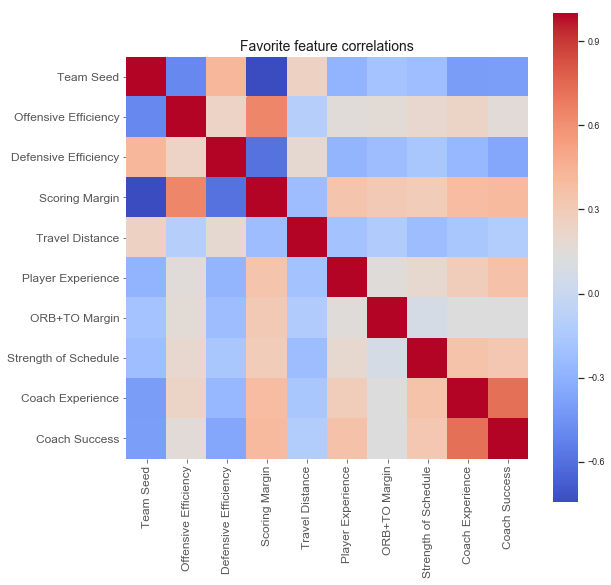

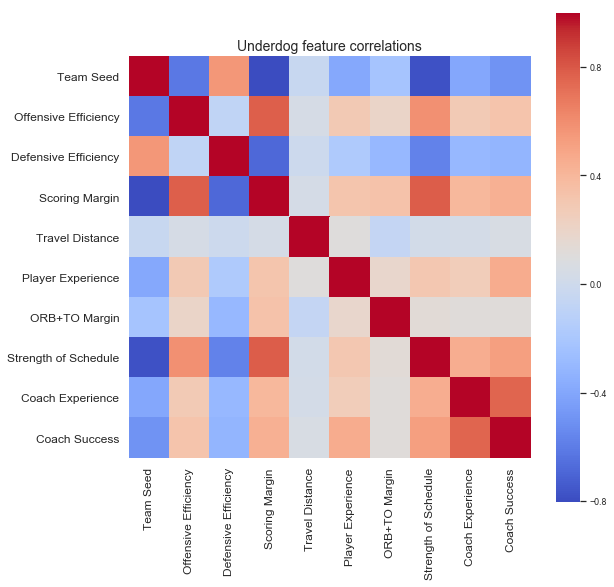

In [13]:
# plot correlation matrix
# favorites
plot_team_correlations('t1')
# underdogs
plot_team_correlations('t2')

Some of the strongest correlations are expected, due to the features representing similar constructs.
- Each team's margin is positively correlated with their offense and negatively correlated with their defense. This is expected since teams with higher margins have offenses that score more points and/or defenses that allow fewer points. 
- Schedule (a measure of schedule difficulty) is positively correlated with offense and margin, and negatively correlated with defense for underdogs. Schedule strength factors into the calculation of these metrics, so it makes sense that teams with more extreme values on strength of schedule would also have more extreme values on these metrics.  
- Margins are negatively correlated with seed, which fits the expectation that teams who win by more points receive more favorable seeds for the tournament.

Other interesting observations:
- The positive correlation between underdog schedule and margin shows that underdogs who schedule tougher opponents during the regular season also outscore their opponents by greater amounts. Many tournament "underdogs" are the dominant teams from small or mid-major conferences who also make it a point to scheudle a few tougher opponents during the season. 
- The positive correlation between underdog coach features (experience & success) and strength of schedule suggests that coaches with previous success in the tournament may push their teams to schedule tougher opponents during the season. Or, it may just mean these coaches tend to coach in conferences with better teams overall. 

### Associations between single features and upsets
One viable strategy for feature selection is to examine "univariate" models where each feature is tested as the only feature in the model. To examine the associations between features and upsets, I'll use logistic regression, which can be used to model a dichotomous outcome from one or more numeric features.

First I define two functions, one to return classification scores that indicate how well each single-feature model predicts upsets, and another to estimate the logistic regression from a single feature and return model results. For each model I obtain the odds ratio and p-value for the feature, along with the classification scores.

In [14]:
# function to return classification scores from model predictions
def get_scores(y_true, y_pred):
    scores = []
    scores.append(accuracy_score(y_true, y_pred))
    scores.append(precision_score(y_true, y_pred))
    scores.append(recall_score(y_true, y_pred))
    scores.append(f1_score(y_true, y_pred))
    scores_rounded = map(lambda x: round(x, 2), scores)
    return scores_rounded

# function to classify upsets from a single feature
def model_univariate(feature):
    # get index of feature to select column in data
    feature_ix = feat_list.index(feature)
    # set up and fit model to training set upsets using single feature
    logit = sm.Logit(y_train, x_train[:, feature_ix])
    result = logit.fit(disp=False)
    # predict probability of upset using fit model
    prob = result.predict(x_train[:, feature_ix])
    threshold = 0.5
    # predict dichotomous upset target from probabilities
    preds = np.array(prob > threshold, dtype=float)
    
    # to label results
    if 't1_' in feature:
        feature_name = "Favorite " + feat_dict[feature[3:]]
    elif 't2_' in feature:
        feature_name = 'Underdog ' + feat_dict[feature[3:]]
    else:
        feature_name = feat_dict[feature]
    odds_ratio = round(np.exp(result.params), 2)
    p_val = round(result.pvalues, 3)
    # list of results for single-feature model
    model_data = [feature_name, odds_ratio, p_val]
    # add scores to list of results
    model_data.extend(get_scores(y_train, preds))
    return model_data

Here I repeat the single-feature model function for each feature and create a dataframe of the results.

In [15]:
# iterate the single-feature model function over the list of features
results = map(lambda x: model_univariate(x), feat_list)

# create dataframe with column labels to match the lists of results
results_columns = ['feature', 'odds_ratio', 'p_value', 'accuracy', 'precision', 'recall',
                   'f1']
df_results = pd.DataFrame(results, columns=results_columns)

To view the results, I sort them by the estimated odds ratio for each feature, from lowest to highest.  
Features with an odds ratio below 1 have a negative association with upsets, where higher feature values indicate less probability of an upset.  
Features with an odds ratio above 1 have a positive association with upsets, where higher feature values indicate greater probability of an upset.  
For all the odds ratios, greater distance from 1 implies a stronger positive or negative association with upsets. 

In [16]:
df_results.sort_values('odds_ratio')

,feature,odds_ratio,p_value,accuracy,precision,recall,f1
3,Favorite Scoring Margin,0.65,0.000,0.56,0.28,0.71,0.40
6,Favorite ORB+TO Margin,0.70,0.000,0.57,0.27,0.67,0.39
12,Underdog Defensive Efficiency,0.75,0.003,0.53,0.26,0.68,0.37
7,Favorite Strength of Schedule,0.75,0.004,0.60,0.28,0.59,0.38
1,Favorite Offensive Efficiency,0.77,0.006,0.57,0.27,0.63,0.37
9,Favorite Coach Success,0.80,0.018,0.57,0.26,0.58,0.36
10,Underdog Team Seed,0.80,0.019,0.59,0.26,0.56,0.36
5,Favorite Player Experience,0.82,0.039,0.49,0.24,0.66,0.35
8,Favorite Coach Experience,0.86,0.117,0.52,0.25,0.67,0.36
14,Underdog Travel Distance,1.00,0.995,0.56,0.22,0.45,0.29


### Summary of single-feature associations with upsets
Games resulting in an upset tended to involve Favorites that:
- outscored their opponents by a smaller margin
- had less of an advantage in offensive rebounds and turnovers
- played a easier schedule prior to the tournament
- had less efficient offense or defense 
- were led by coaches with less peak success in prior tournaments
- were assigned a higher seed value

And underdogs in upset games tended to be those that:
- typically outscore their opponents by larger amounts
- had a greater advantage in offensive rebounds and turnovers
- played a more difficult schedule prior to the tournament
- had more efficient offense or defense
- were assigned a lower seed value for the tournament

All of these results make sense. The features for favorites all reflect a worse team, while the features for underdogs reflect a higher quality team. 

### Feature selection

From these results, I choose to retain 8 features for the classification model. For both favorites and underdogs, I use scoring margin, offensive rebound + turnover margin, strength of schedule, and seed.  Each of these factors was associated with upsets in the training data. 

Even though offense and defense were associated with upsets, I chose not to include them, because both of those metrics are "baked in" to the scoring margin feature, and the scoring margin feature has a stronger association with upsets than either offense or defense alone. In general, I want to include features that represent unique information, and not include too many features that reperesent overlapping information. 

In [17]:
# create list of features to keep
features_keep = ['t1_em', 't2_em', 't1_seed', 't2_seed',
                 't2_orbtomarg', 't1_orbtomarg', 't2_sos', 't1_sos']
features_keep_ix = [feat_list.index(x) for x in features_keep]
x_train_sel = x_train[:, features_keep_ix]

## Training the classification model for upset prediction

So far, I have used the training data to look at associations between features and the target variable (upsets) within the training examples. But the purpose of the upset classification model is make predictions on unseen data (new games that haven't occurred yet). With this goal in mind, I need to test how well the model performs when trained on one set of data, and used to make predictions on another "held-out" set of data.

Earlier I held out the games from 2014-2016 (22% of the games) to use as "test set". But I don't want to use that data here, because I am still building and adjusting the model, and if I use that test set to make adjustments to the model, subsequent predictions on that test set will no longer be unbiased estimates of how the model would perform on future, unseeen data. 

Instead, I will use k-fold cross-validation to estimate out-of-sample performance when building and adjusting the model. 

### *K*-fold cross-validation
With k-fold cross-validation, I split the training data into *k* number of "folds". Here I choose k = 5, so each fold is roughly 1/5 of the training data. For each fold, I make predictions for that fold using a model trained on the other 4/5 of the data, and compute a classification score from all of these "cross-validated" predictions. 

Here I demonstrate 5-fold cross-validation with a non-regularized logistic regression model.  
First I create a cross-validator object to use to to divide the data into folds. In order to compare my results across different models, the cross-validation folds need to stay consistent. 

In [18]:
# create cross-validator to use the same folds for every analysis 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=489)

After setting up a classification model, I input the model, the cross-validator, and the data to the a cross-validation predict function that generates cross-validated predictions for all the examples in the dataset. 

In [19]:
# set high C parameter value to examine "non-regularized model"
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0, C=100000)

# get cross-validated predictions for all games
preds = cross_val_predict(clf, x_train_sel, y_train, cv=kf)

Using the get_score function I created earlier, I obtain the classification scores and print them for interpretation. 

In [20]:
# list of scores from non-regularized model
scores_0 = get_scores(y_train, preds)
score_names = ['Accuracy', 'Precision', 'Recall', 'F1']
for n, s in zip(score_names, scores_0):
    print n, s

Accuracy 0.8
Precision 0.51
Recall 0.2
F1 0.29


The model has decent accuracy, but accuracy is a misleading score to use for this problem. Because upsets make up 20% of the training set, the model could achieve 80% accuracy simply by predicting "not upset" every time. 
The model has fairly unimpressive results on the other scores. The model predicts only 20% of the true upsets as upsets (Recall), and the model's upset predictions are correct only 51% of the time (Precision).  
In order for this model to be useful for predicting upsets, it would be useful to increase both Precision and Recall. 

### Improve model performance through regularization
Performance of the model on out-of-sample data can likely be improved by using regularization. In a nutshell, regularization is a way of penalizing extreme predictions so that the model generalizes well to data that wasn't used in model training.  
In the logistic regression model, regularization type is controlled with the categorical *penalty* hyperparameter, and the "strength" or magnitude of regularization is controlled with the numeric *C* hyperparameter. By trying different values for these hyperparameters, I can develop a model that performs better when predicting out-of-sample data. 

First I define two functions, one to obtain the scores of cross-validation predictions from a classification model, and another  function to print them. These are two tasks I will repeat several times as I work to improve the model. 

In [21]:
# create function to cross-validate model and return scores
def get_cv_scores(model, x, y):
    score_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    preds = cross_val_predict(model, x, y, cv=kf)
    scores = get_scores(y, preds)
    score_dict = dict(zip(score_names, scores))
    return score_dict

def print_cv_scores(score_dict):
    for x in score_dict:
        print x, score_dict[x]

Now I perform cross-validation with the logistic regression model with two different types of regularization, *Lasso* and *Ridge*, with the default *C* value for both types. 

In [22]:
# obtain and print cross-validation scores for regularized models
# l1 regularization
clf_l1 = LogisticRegression(penalty = 'l1', solver='liblinear', random_state=0, C=1.0)
print 'l1 (lasso) regularization'
print_cv_scores(get_cv_scores(clf_l1, x_train_sel, y_train))
print 'l2 (ridge) regularization'
clf_l2 = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0, C=1.0)
print_cv_scores(get_cv_scores(clf_l2, x_train_sel, y_train))

l1 (lasso) regularization
Recall 0.17
F1 0.26
Precision 0.52
Accuracy 0.8
l2 (ridge) regularization
Recall 0.2
F1 0.29
Precision 0.53
Accuracy 0.8


### Tuning hyperparameter values

Regularization does improve the cross-validation predictions, but from my experience the default hyperparameter values often leave much room for improvement. Better values might by identified by using a hyperparameter search, where cross-validation is repeated for different values of the hyperparameter. 

Two different approaches for hyperparameter search are grid search and random search. I will test both approaches below. 

#### Grid search
In a grid search, cross-validation is repeated for specific values of the hyperparameter that I provide. 
To perform the search, I create a dictionary where each key is the string of one of the model's hyperparameters, and each value is a list of the hyperparameter's values to try in the model.  
For the logistic regression classifier, I provide 6 values of C, and the two regularization types.  
From this dictionary, the grid-search will fit a model for each unique combination of hyperparameters, 12 unique models.

In [23]:
# create hyperparameter grid dictionary for search
params_gs = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 20.0],
             'penalty': ['l1', 'l2']}

The grid search object also accepts a scoring parameter, to automatically calculate and record a classification score for iteration of the search.  
For upset prediction I want to maximize both of precision (percentage of upset predictions correct) and recall (percentage of true upsets predicted). So I use the *F1* score, which is the weighted average of precision and recall. 

In [24]:
# score for grid search object to report
score_type = 'f1'

I also need to initialize a base version of the model to input to the grid search. No hyperparameter values are set, because the grid search will set them using the dictionary I created above. 

In [25]:
# base classifier 
clf = LogisticRegression(random_state=0, solver='liblinear')

To set up the grid search object I first initialize the grid search object with a classifier, the hyperparameter value dictoinary, the score type, and the cross-validator object. By inputting the same k-fold cross-validator object I used above, I ensure that the cross-validated predictions and classification scores from the grid search are comparable to the previous results.  

In [26]:
# basic classifier
gs = GridSearchCV(estimator=clf,
                  param_grid=params_gs,
                  scoring=score_type,
                  cv=kf,
                  iid=False,
                  n_jobs=-1,
                  return_train_score=True)

To perform the grid search, the grid search object is fit to the training data. 

In [27]:
gsf = gs.fit(x_train_sel, y_train)

After fitting, the grid search object contains a results dictionary with detailed information about the search.  
I'm interested mainly in the cross-validated *F1* score and the hyperparameter values for each iteration, so I select and show these results below. 

In [28]:
# list of columns to show in results dataframe
cols_show = ['mean_test_score', 'mean_train_score', 'param_C', 'param_penalty']
# create dataframe from the grid search results dict
results_gs = pd.DataFrame.from_dict(gsf.cv_results_)
# sort to show iterations with 5 best scores
results_gs = results_gs.sort_values('mean_test_score', ascending=False).reset_index()
results_gs[cols_show].head(5)

,mean_test_score,mean_train_score,param_C,param_penalty
0,0.438210,0.446485,0.0001,l2
1,0.402478,0.424580,0.001,l2
2,0.295069,0.296885,1,l2
3,0.292402,0.296314,10,l1
4,0.292402,0.295131,10,l2


The highest *F1* score was 0.438, produced by the model with *L2* regularization and *C* of 0.0001.  
To assess this model in greater detail I examine the other classification scores. 

In [29]:
best_C = results_gs.loc[0, 'param_C']
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0, C=best_C)
print 'ridge regularization, C=0.0001'
print_cv_scores(get_cv_scores(clf, x_train_sel, y_train))

ridge regularization, C=0.0001
Recall 0.41
F1 0.44
Precision 0.47
Accuracy 0.79


The model with the top F1 score does seem to balance precision and recall, with 41% of the true upsets predicted as upsets, and 47% of the upsets predictions being correct. This is an improvement over the Logistic Regression with default regularization strength, because of a big increase in Recall (0.20 to 0.41). This model predicts twice as many of the true upsets. 

#### Random hyperparameter search
The grid search approach is limited by the fact that it only tests the specific values I provide. It's quite possible that I fail to provide the value that would maximize cross-validation *F1*.  
A random hyperparameter search helps address this limitation, by testing random values of each hyperparameter within a specified range, for a specified number of iterations. 

For inputs to the random search object, I create a dictionary with a random number function for the *C* hyperparameter. For this dictionary, I don't include the penalty hyperparameter. Because none of the Lasso models scored well in the grid search above, I only include the Ridge models in the random search.

In [30]:
np.random.seed(seed=204181)
params_rs = {'C': sp_uniform(0.00005, 0.005)}

The process for setting up and fitting the randomized search is nearly identical to the grid search, with two small differences.  
- I set the *l2* penalty type for the classifier, because I want the search to only use this type
- With the *n_iter* parameter, I provide a number of iterations for the search. Whereas the grid search performed the number of iterations that was necessary to test all unique hyperparameter combinations, the random search performs a specified number of iterations. 

In [31]:
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0)
rs = RandomizedSearchCV(clf,
                        param_distributions=params_rs,
                        n_iter = 30,
                        scoring=score_type,
                        cv=kf,
                        iid=False,
                        n_jobs=-1,
                        return_train_score=True)
rsf = rs.fit(x_train_sel, y_train)

As with the grid search, I want to see which hyperparameter values produced the best *F1* scores. 

In [32]:
# random search results don't include 'param_penalty'
cols_show_rs = [x for x in cols_show if x is not 'param_penalty']
results_rs = pd.DataFrame.from_dict(rsf.cv_results_)
results_rs = results_rs.sort_values('mean_test_score', ascending=False).reset_index()
results_rs[cols_show_rs].head(5)

,mean_test_score,mean_train_score,param_C
0,0.438210,0.446485,0.000100428
1,0.438210,0.446485,9.20397e-05
2,0.408573,0.439589,0.000506701
3,0.408573,0.431151,0.00071728
4,0.408573,0.441547,0.000533631


In [33]:
best_C = results_rs.loc[0, 'param_C']
clf = LogisticRegression(penalty = 'l2', solver='liblinear',random_state=0, C=best_C)
print 'ridge regularization, C= %s' % (round(best_C, 6))
print_cv_scores(get_cv_scores(clf, x_train_sel, y_train))

ridge regularization, C= 0.0001
Recall 0.41
F1 0.44
Precision 0.47
Accuracy 0.79


The best cross-validation *F1* score from the random search (0.41) is also an improvement over the default regularized Logistic Regression, but not quite as high as from the grid search (0.43). 

### Regularization without pre-selection of features

The training set used in the grid search was one where the features had been pre-screened based on the results from univariate models. Although guided feature selection can be useful in practice, it's worth testing whether including all 20 features in the training set might improve model performance.

Here I repeat both grid searches using all 20 features. 

In [34]:
clf = LogisticRegression(random_state=0, solver='liblinear')
gs = GridSearchCV(estimator=clf,
                  param_grid=params_gs,
                  scoring=score_type,
                  cv=kf,
                  iid=False,
                  n_jobs=-1,
                  return_train_score=True)
gsf = gs.fit(x_train, y_train)
results_gs_20 = pd.DataFrame.from_dict(gsf.cv_results_)
results_gs_20 = results_gs_20.sort_values('mean_test_score', ascending=False).reset_index()
results_gs_20[cols_show].head(5)

,mean_test_score,mean_train_score,param_C,param_penalty
0,0.484606,0.491414,0.001,l2
1,0.472823,0.483529,0.0001,l2
2,0.290540,0.376555,0.01,l2
3,0.277736,0.360534,1,l2
4,0.271265,0.360534,10,l1


In a grid search using all 20 features in the training data, the cross-validation *F1* score is improved to 0.48. 

In [35]:
best_C = results_gs_20.loc[0, 'param_C']
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0, C=best_C)
print '20 features, ridge regularization, C=0.001'
print_cv_scores(get_cv_scores(clf, x_train, y_train))

20 features, ridge regularization, C=0.001
Recall 0.54
F1 0.49
Precision 0.44
Accuracy 0.77


In cross-validation this model predicts 57% of the true upsets as upsets, and is correct on 40% of the upset predictions. 

In [ ]:
np.random.seed(seed=204181)
params_rs = {'C': sp_uniform(0.00005, 0.005)}

In [40]:
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0)
rs = RandomizedSearchCV(clf,
                        param_distributions=params_rs,
                        n_iter = 30,
                        scoring=score_type,
                        cv=kf,
                        iid=False,
                        n_jobs=-1,
                        return_train_score=True)
rsf = rs.fit(x_train, y_train)
results_rs_20 = pd.DataFrame.from_dict(rsf.cv_results_)
results_rs_20 = results_rs_20.sort_values('mean_test_score', ascending=False).reset_index()
results_rs_20[cols_show_rs].head()

,mean_test_score,mean_train_score,param_C
0,0.483913,0.490847,0.000699687
1,0.483913,0.490847,0.000678152
2,0.483913,0.490847,0.000691619
3,0.482473,0.483158,0.00122555
4,0.479746,0.488467,0.000589299


In [41]:
best_C = results_rs_20.loc[0, 'param_C']
clf = LogisticRegression(penalty = 'l2', solver='liblinear', random_state=0, C=best_C)
print '20 features, ridge regularization, C= %s' % (best_C)
print_cv_scores(get_cv_scores(clf, x_train, y_train))

20 features, ridge regularization, C= 0.0006996868352730606
Recall 0.55
F1 0.48
Precision 0.43
Accuracy 0.76


The random search with all 20 features identifies a model with cross-validation *F1* of 0.486, which is similar to the best cross-validation *F1* score found in the grid search.  

In this case, selecting a smaller subset of the features was detrimental to the cross-validation performance, which illustrates the value of experimenting with different feature sets. Also, the smaller subset of 8 features was selected based on degree of association within the full training set, which may not be the best way to select features when building a model for out-of-sample predictions. 

## Estimate future performance using the test set

Finally, I will use the final model from cross-validation to make predictions on the test set. 

In [44]:
clf = LogisticRegression(penalty='l2', solver='liblinear', random_state=0, C=0.000699)
clf.fit(x_train, y_train)
preds_train = clf.predict(x_train)
preds_test = clf.predict(x_test)

Below I print the classification scores for predictions made on the test set, with the scores from cross-validation also shown for comparison. 

In [45]:
scores_test = get_scores(y_test, preds_test)
scores_cv = get_cv_scores(clf, x_train, y_train)

for n, tst in zip(score_names, scores_test):
    print n
    print "Test: %s" % (tst)
    print "Cross-validation: %s" % (scores_cv[n])
    print ""

Accuracy
Test: 0.72
Cross-validation: 0.76

Precision
Test: 0.45
Cross-validation: 0.43

Recall
Test: 0.29
Cross-validation: 0.55

F1
Test: 0.36
Cross-validation: 0.48



## Summary and conclusions

By training and tuning a classification model using cross-validation, my goal was to follow a reproducible process that maximizes performance of the model on future, unseen data. In this case, I selected models to maximixe the *F1* score, although the test set *F1* of 0.36 is well short of the cross-validation *F1* of 0.49, the model's predictions may still be useful, and there are several areas for future improvement. 

By using this model to predict upsets in 2014-2016, 29% of the true upsets would have been predicted, and 45% of the upset predictions would have been correct. In a vacuum, this may seem like a low rate of success, but considering that underdog winners are only picked correctly 20% of the time, the model offers better predictions than the typical bracket contest participant will achieve on their own. 

From a sports gambling perspective, achievement of 0.45 precision on the test set may also be favorable. Even if less than half of bets on underdogs are correct, the rate of return is likely to be positive, since the odds on underdogs are typically greater than 1:1, and sometimes much greater. 

There are also several paths for improvement, including testing other classification algorithms, training the model using more features, and using strategies for classifying imbalanced data. Like many classification algorithms, logistic regression typically performs best when the target variable is balanced at or near 50%. In this dataset, the "positive" targets (the upsets) only comprise 20% of the examples. Classification performance may improve when using strategies designed to address imbalanced data. My future work will test these approaches. 